In [21]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
import imp
imp.reload(KalmanInversion )
imp.reload(NeuralNet )


<module 'NeuralNet' from '../Utility/NeuralNet.py'>

# Load Training data

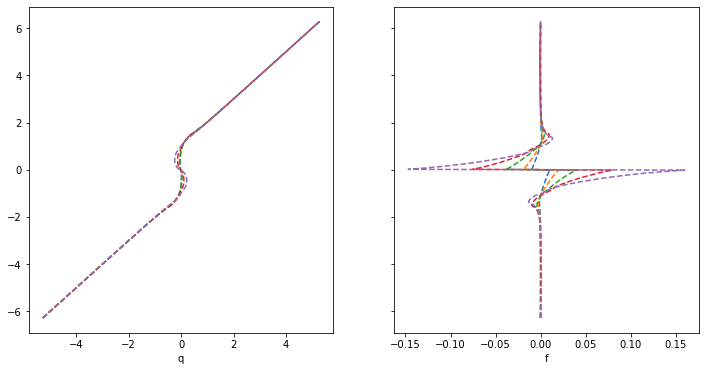

In [16]:
Nx = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)

data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

L = 4*np.pi
xx, closure_mean,  q_mean, dq_dx_mean = np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dx_mean[i, :] = load_data(data_dirs[i])
    xx[i, :] = np.linspace(-L/2.0, L/2.0, Nx)
dx = xx[0, 1] - xx[0, 0]


# TODO: clean data
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
q_jet = omega_jet + beta*xx[0, :]


f = np.zeros(q_mean.shape)

chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)   #q_jet[-chop_l:]
    
    
    dq_dx_mean[i, 0:chop_l] = np.linspace(beta, dq_dx_mean[i,chop_l-1],  chop_l)
    dq_dx_mean[i, -chop_l:] = np.linspace(dq_dx_mean[i, -chop_l], beta, chop_l)
    
    closure_mean[i, 0:chop_l] = np.linspace(0.0, closure_mean[i,chop_l-1],  chop_l)
    closure_mean[i, -chop_l:] = np.linspace(closure_mean[i, -chop_l], 0.0, chop_l)
    
    
    
    
    f[i, :] = tau_inv[i]*(q_jet - q_mean[i, :])

q_mean_abs = np.fabs(q_mean)
mu_f = closure_mean/dq_dx_mean
# visualize data

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,6))
for i in range(N_data):
    ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("q")
ax[1].set_xlabel("f")   
plt.show()



# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [17]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    

    net =  create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    
    nn_model = partial(nn_flux, net)
    
    for i in range(N_data):
        nummodel(nn_model, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))


## Start UKI

In [18]:
class PoissonParam:
    def __init__(self, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer, aug=True):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta if aug else N_y

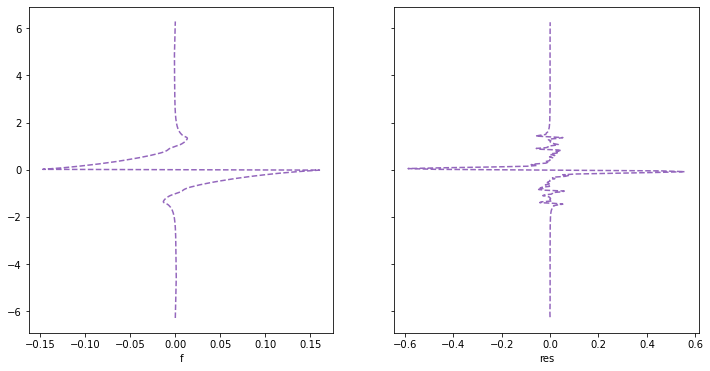

In [19]:
aug = True

y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(N_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*1.0)**2, -1))


N_y = len(y)
ind, outd, width = 2, 1, 10
layers = 2
activation, initializer, outputlayer = "sigmoid", "default", "None"

s_param = PoissonParam(xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer, aug)


N_theta = s_param.N_theta


# theta0_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()

theta0_init = torch.load("visc.model").get_params()

res = loss_aug(s_param, theta0_init)[0:N_y].reshape((N_data,-1))


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,6))
for i in range(4,5):
    ax[0].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
    #ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(-res[i, :], xx[i,1:-1],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("f")
ax[1].set_xlabel("res")   
plt.show()


In [33]:
aug = True

y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(N_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*1.0)**2, -1))


N_y = len(y)
ind, outd, width = 2, 1, 10
layers = 2
activation, initializer, outputlayer = "sigmoid", "default", "None"

s_param = PoissonParam(xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer, aug)


N_theta = s_param.N_theta


# theta0_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()

# theta0_init = torch.load("visc.model").get_params()

theta0_init = np.zeros(N_theta)
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 100.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)
print(" N_theta = ", s_param.N_theta, " N_y = ", s_param.N_y)
print(" q = ", s_param.q.shape)


alpha_reg = 1.0
update_freq = 1
N_iter = 10
gamma = 1.0

if aug:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
        theta0_mean, theta0_init, theta0_cov,
        y_aug, Sigma_eta_aug,
        alpha_reg,
        gamma,
        update_freq, 
        N_iter)
else:
    uki_obj = KalmanInversion.UKI_Run(s_param, loss, 
        theta0_mean, theta0_init, theta0_cov,
        y, Sigma_eta,
        alpha_reg,
        gamma,
        update_freq,
        N_iter)

trained_net = create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])

 N_theta =  41  N_y =  1951
 q =  (5, 384)
ukiobj.gamma :  1.0
len(ukiobj.opt_error) :  0 1
optimization error at iter  0  =  6025.856635589709
[-1.64647879e-04 -1.39713713e-04 -1.29551952e-04 -1.13974685e-04
 -1.13073676e-04 -1.14046017e-04 -9.09078797e-05 -5.88310910e-05
 -3.92463007e-05 -3.22729317e-05 -3.19111129e-05 -3.01145947e-05
 -2.12532853e-05 -1.25298572e-05 -1.17292233e-05 -1.45213977e-05
 -1.36433054e-05 -9.88556758e-06 -5.72387988e-06  2.56736541e-07
  8.30223749e-06  1.53026462e-05  2.31308471e-05  3.24699314e-05
  4.69543679e-05  1.10294541e-04  2.61238803e-04  3.17261918e-04
  1.01515507e-05 -3.02961914e-04 -2.59479099e-04 -1.16032502e-04
 -5.57721064e-05 -4.10887566e-05 -2.68766802e-05 -1.44006823e-05
 -7.40285710e-06 -2.14583383e-06  2.71067091e-06  5.83811063e-06
  6.15913022e-06  6.95898678e-06  1.18949074e-05  1.91505895e-05
  2.43894089e-05  2.61555793e-05  2.62646897e-05  3.12326222e-05
  4.54732170e-05  5.84704655e-05  6.27096329e-05  7.91333435e-05
  1.1806704

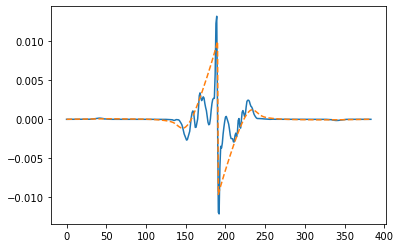

In [35]:
plt.plot(uki_obj.y_pred[-1][0:384])
plt.plot(uki_obj.y[0:384], "--")

In [36]:
trained_net = create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])

In [37]:
Sigma_eta

array([[8.71988747e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.71988747e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.71988747e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.03402627e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.03402627e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.03402627e-04]])

In [38]:
print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ -55.9421, -303.3991],
        [   2.0000, -262.1452],
        [ -50.9249, -288.4973],
        [ -59.6596, -130.9613],
        [  93.3805, -285.8058],
        [  28.0654, -235.4358],
        [ -16.8896, -335.0515],
        [  -8.4472, -360.5934],
        [ -90.6887, -289.7201],
        [ -21.2975, -282.0727]], requires_grad=True)
Parameter containing:
tensor([ -9.3578,  99.8883,  -4.2690,   4.3247, -80.1927, -63.6283,  36.8377,
        -60.6624, -28.9460,  63.3888], requires_grad=True)
Parameter containing:
tensor([[ 2.9261e+01,  9.9641e-01, -2.4856e+01, -3.4671e+01,  6.0921e-03,
          1.7429e+01,  9.5964e+00, -6.2726e+01,  6.5058e+01, -2.4979e-01]],
       requires_grad=True)
Parameter containing:
tensor([0.0046], requires_grad=True)


# Direct test

/central/home/dzhuang/Code/Point-Jet/Point_jet/Solver.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten() * mu_scale


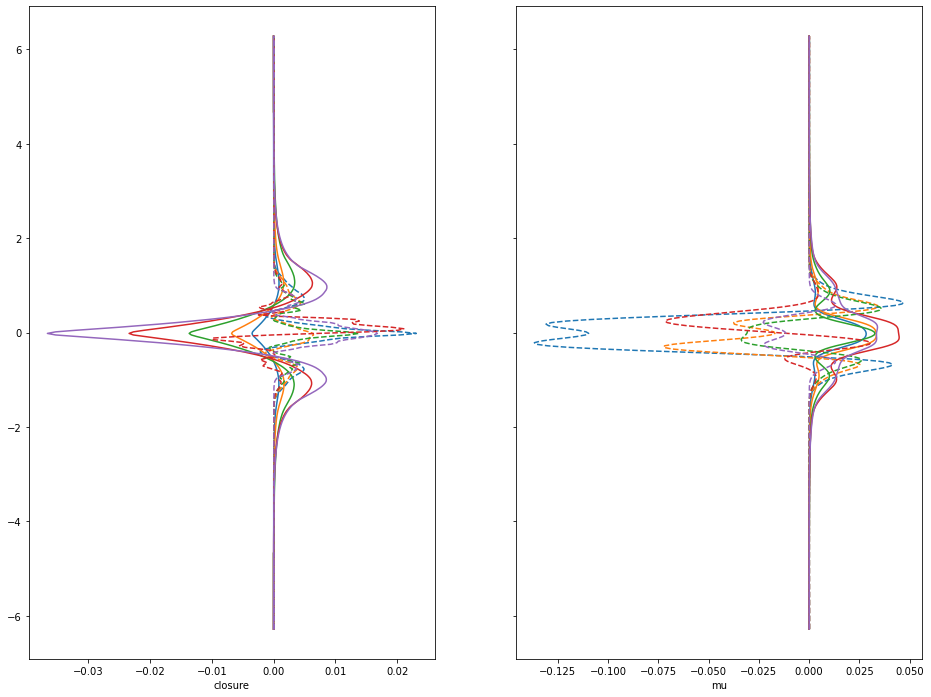

In [39]:
Nx = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dx_mean = np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dx_mean[i, :] = load_data(data_dirs[i])
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dx_mean
L = 4*np.pi
xx = np.linspace(-L/2.0, L/2.0, Nx)
dx = xx[1] - xx[0]


# q_jet 
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
q_jet = omega_jet + beta*xx


chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = q_jet[0:chop_l]
    q_mean[i, -chop_l:] = q_jet[-chop_l:]
    q_mean_abs[i, 0:chop_l] = np.fabs(q_mean[i, 0:chop_l])
    q_mean_abs[i, -chop_l:] = np.fabs(q_mean[i, -chop_l:])
    dq_dx_mean[i, 0:chop_l] = beta
    dq_dx_mean[i, -chop_l:] = beta
    closure_mean[i, 0:chop_l] = 0.0
    closure_mean[i, -chop_l:] = 0.0
    mu_f[i, 0:chop_l] = 0.0
    mu_f[i, -chop_l:] = 0.0
    
    
# TODO: clean data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)


x_train = torch.from_numpy(np.stack((np.fabs(q_mean.flatten()), dq_dx_mean.flatten())).T.astype(np.float32)) 
y_pred = net_eval(x_train, trained_net).reshape((N_data, Nx))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], xx, color="C"+str(i))
    ax[1].plot(mu_f[i,:], xx, color="C"+str(i))
    
    ax[0].plot(y_pred[i,:]*dq_dx_mean[i,:], xx, "--", color="C"+str(i))
    ax[1].plot(y_pred[i,:], xx, "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")
    

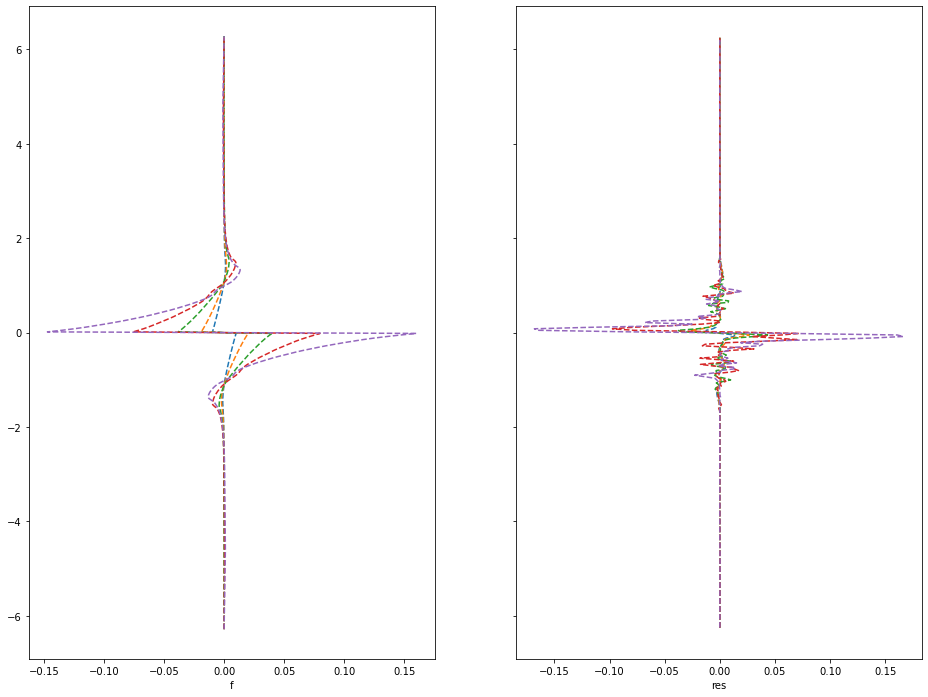

In [42]:
res = loss_aug(s_param, uki_obj.theta_mean[-1])[0:N_y].reshape((N_data,-1))


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,12))
for i in range(N_data):
    ax[0].plot(f[i, :], xx,  "--", fillstyle="none", color="C"+str(i))
    
    #ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(res[i, :], xx[1:-1],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("f")
ax[1].set_xlabel("res")   
plt.show()

# Plug-in test

1000 max q 5.283185307179586
2000 max q 5.283185307179586
3000 max q 5.283185307179586
4000 max q 5.283185307179586
5000 max q 5.283185307179586
6000 max q 5.283185307179586
7000 max q 5.283185307179586
8000 max q 5.283185307179586
9000 max q 5.283185307179586
10000 max q 5.283185307179586
11000 max q 5.283185307179586
12000 max q 5.283185307179586
13000 max q 5.283185307179586
14000 max q 5.283185307179586
15000 max q 5.283185307179586
16000 max q 5.283185307179586
17000 max q 5.283185307179586
18000 max q 5.283185307179586
19000 max q 5.283185307179586
20000 max q 5.283185307179586
21000 max q 5.283185307179586
22000 max q 5.283185307179586
23000 max q 5.283185307179586
24000 max q 5.283185307179586
25000 max q 5.283185307179586
26000 max q 5.283185307179586
27000 max q 5.283185307179586
28000 max q 5.283185307179586
29000 max q 5.283185307179586
30000 max q 5.283185307179586
31000 max q 5.283185307179586
32000 max q 5.283185307179586
33000 max q 5.283185307179586
34000 max q 5.28318

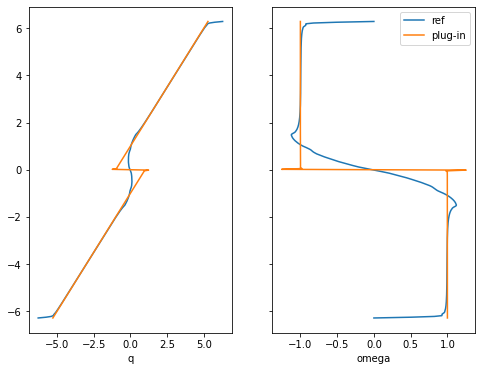

In [41]:
beta = 1.0
Nx = 384
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, Nx)
q_jet = omega_jet + beta*yy


tau_inv = "0.08"                                                                                                               
tau = 1/float(tau_inv)
data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

_, Ny, Nt = q.shape
q_mean = np.mean(q[0, :, Nt//2:], axis=1)
w_mean = np.mean(w[0, :, Nt//2:], axis=1)



nn_model = partial(nn_flux, trained_net)

model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
dt, Nt, save_every = 1.0e-4, 200000, 1000
yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = 4*np.pi)
q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(w_mean, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
plt.show()